In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/garbage-classification/one-indexed-files-notrash_val.txt
/kaggle/input/garbage-classification/one-indexed-files-notrash_train.txt
/kaggle/input/garbage-classification/zero-indexed-files.txt
/kaggle/input/garbage-classification/one-indexed-files.txt
/kaggle/input/garbage-classification/one-indexed-files-notrash_test.txt
/kaggle/input/garbage-classification/Garbage classification/Garbage classification/metal/metal375.jpg
/kaggle/input/garbage-classification/Garbage classification/Garbage classification/metal/metal341.jpg
/kaggle/input/garbage-classification/Garbage classification/Garbage classification/metal/metal374.jpg
/kaggle/input/garbage-classification/Garbage classification/Garbage classification/metal/metal383.jpg
/kaggle/input/garbage-classification/Garbage classification/Garbage classification/metal/metal215.jpg
/kaggle/input/garbage-classification/Garbage classification/Garbage classification/metal/metal113.jpg
/kaggle/input/garbage-classification/Garbage classifi

In [2]:
import os
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import cv2 
import tensorflow as tf
import random
import shutil             # to copy images to another directory 
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report , confusion_matrix

from tqdm import tqdm
from keras.layers import Conv2D, MaxPooling2D , BatchNormalization ,Dropout ,Flatten , Dense , Input , Rescaling , Resizing
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.applications import MobileNetV2

import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
plt.style.use('ggplot')

In [3]:
dataDirList = ['/kaggle/input/garbage-classification/Garbage classification/Garbage classification/' , 
              '/kaggle/input/d/mostafaabla/garbage-classification/garbage_classification/']

selectedClasses = ['metal', 'glass', 'paper', 'trash', 'cardboard', 'plastic' ,'white-glass']

In [4]:
imgPaths = []
labels = []
for dataDir in dataDirList:
    for className in os.listdir(dataDir):
        if className in selectedClasses :
            classPath = os.path.join(dataDir,className)
            for img in os.listdir(classPath):
                imgPath = os.path.join(classPath,img)
                imgPaths.append(imgPath)
                if className == 'white-glass':
                    className = 'glass'
                labels.append(className)
            
# Convert the 2 lists to dataframe to easy use 
df = pd.DataFrame({
    'imgPath':imgPaths,
    'label':labels
})

df = df.sample(frac=1).reset_index(drop=True)            # Shuffle

df

imgPath      label
0     /kaggle/input/d/mostafaabla/garbage-classifica...  cardboard
1     /kaggle/input/garbage-classification/Garbage c...      paper
2     /kaggle/input/garbage-classification/Garbage c...      glass
3     /kaggle/input/garbage-classification/Garbage c...      metal
4     /kaggle/input/d/mostafaabla/garbage-classifica...      glass
...                                                 ...        ...
7569  /kaggle/input/d/mostafaabla/garbage-classifica...      metal
7570  /kaggle/input/d/mostafaabla/garbage-classifica...      trash
7571  /kaggle/input/garbage-classification/Garbage c...    plastic
7572  /kaggle/input/garbage-classification/Garbage c...      paper
7573  /kaggle/input/garbage-classification/Garbage c...      metal

[7574 rows x 2 columns]

In [5]:
def DataFrameSpliting(df , ratio , classesList):
    
    trainDf = pd.DataFrame(columns = ['imgPath','label'])
    testDf = pd.DataFrame(columns = ['imgPath','label'])
    for clas in classesList :
        tempDf = df[df['label'] == clas]
        lastIndex = int(len(tempDf) * ratio)
        trainClassDf = tempDf[:lastIndex]
        testClassDf = tempDf[lastIndex:]
        trainDf = pd.concat([trainDf , trainClassDf] , axis=0)
        testDf = pd.concat([testDf , testClassDf] , axis=0)
        
    return trainDf.sample(frac=1).reset_index(drop=True) , testDf.sample(frac=1).reset_index(drop=True)  # shuffling , reset index

In [6]:
classList = list(df['label'].unique())
trainDf , testDf = DataFrameSpliting(df , 0.85 , classList)

In [7]:
trainDf

imgPath      label
0     /kaggle/input/garbage-classification/Garbage c...      glass
1     /kaggle/input/garbage-classification/Garbage c...      paper
2     /kaggle/input/d/mostafaabla/garbage-classifica...      paper
3     /kaggle/input/d/mostafaabla/garbage-classifica...  cardboard
4     /kaggle/input/d/mostafaabla/garbage-classifica...      trash
...                                                 ...        ...
6429  /kaggle/input/garbage-classification/Garbage c...      glass
6430  /kaggle/input/d/mostafaabla/garbage-classifica...      glass
6431  /kaggle/input/garbage-classification/Garbage c...      paper
6432  /kaggle/input/d/mostafaabla/garbage-classifica...      paper
6433  /kaggle/input/garbage-classification/Garbage c...    plastic

[6434 rows x 2 columns]

In [8]:
trainDf['label'].value_counts()

label
paper        1397
plastic      1144
cardboard    1099
glass        1084
metal        1002
trash         708
Name: count, dtype: int64

In [9]:
testDf

imgPath    label
0     /kaggle/input/d/mostafaabla/garbage-classifica...  plastic
1     /kaggle/input/d/mostafaabla/garbage-classifica...    paper
2     /kaggle/input/garbage-classification/Garbage c...  plastic
3     /kaggle/input/d/mostafaabla/garbage-classifica...  plastic
4     /kaggle/input/d/mostafaabla/garbage-classifica...    paper
...                                                 ...      ...
1135  /kaggle/input/garbage-classification/Garbage c...    metal
1136  /kaggle/input/garbage-classification/Garbage c...    metal
1137  /kaggle/input/garbage-classification/Garbage c...    trash
1138  /kaggle/input/d/mostafaabla/garbage-classifica...    paper
1139  /kaggle/input/garbage-classification/Garbage c...    metal

[1140 rows x 2 columns]

In [10]:
testDf['label'].value_counts()

label
paper        247
plastic      203
cardboard    195
glass        192
metal        177
trash        126
Name: count, dtype: int64

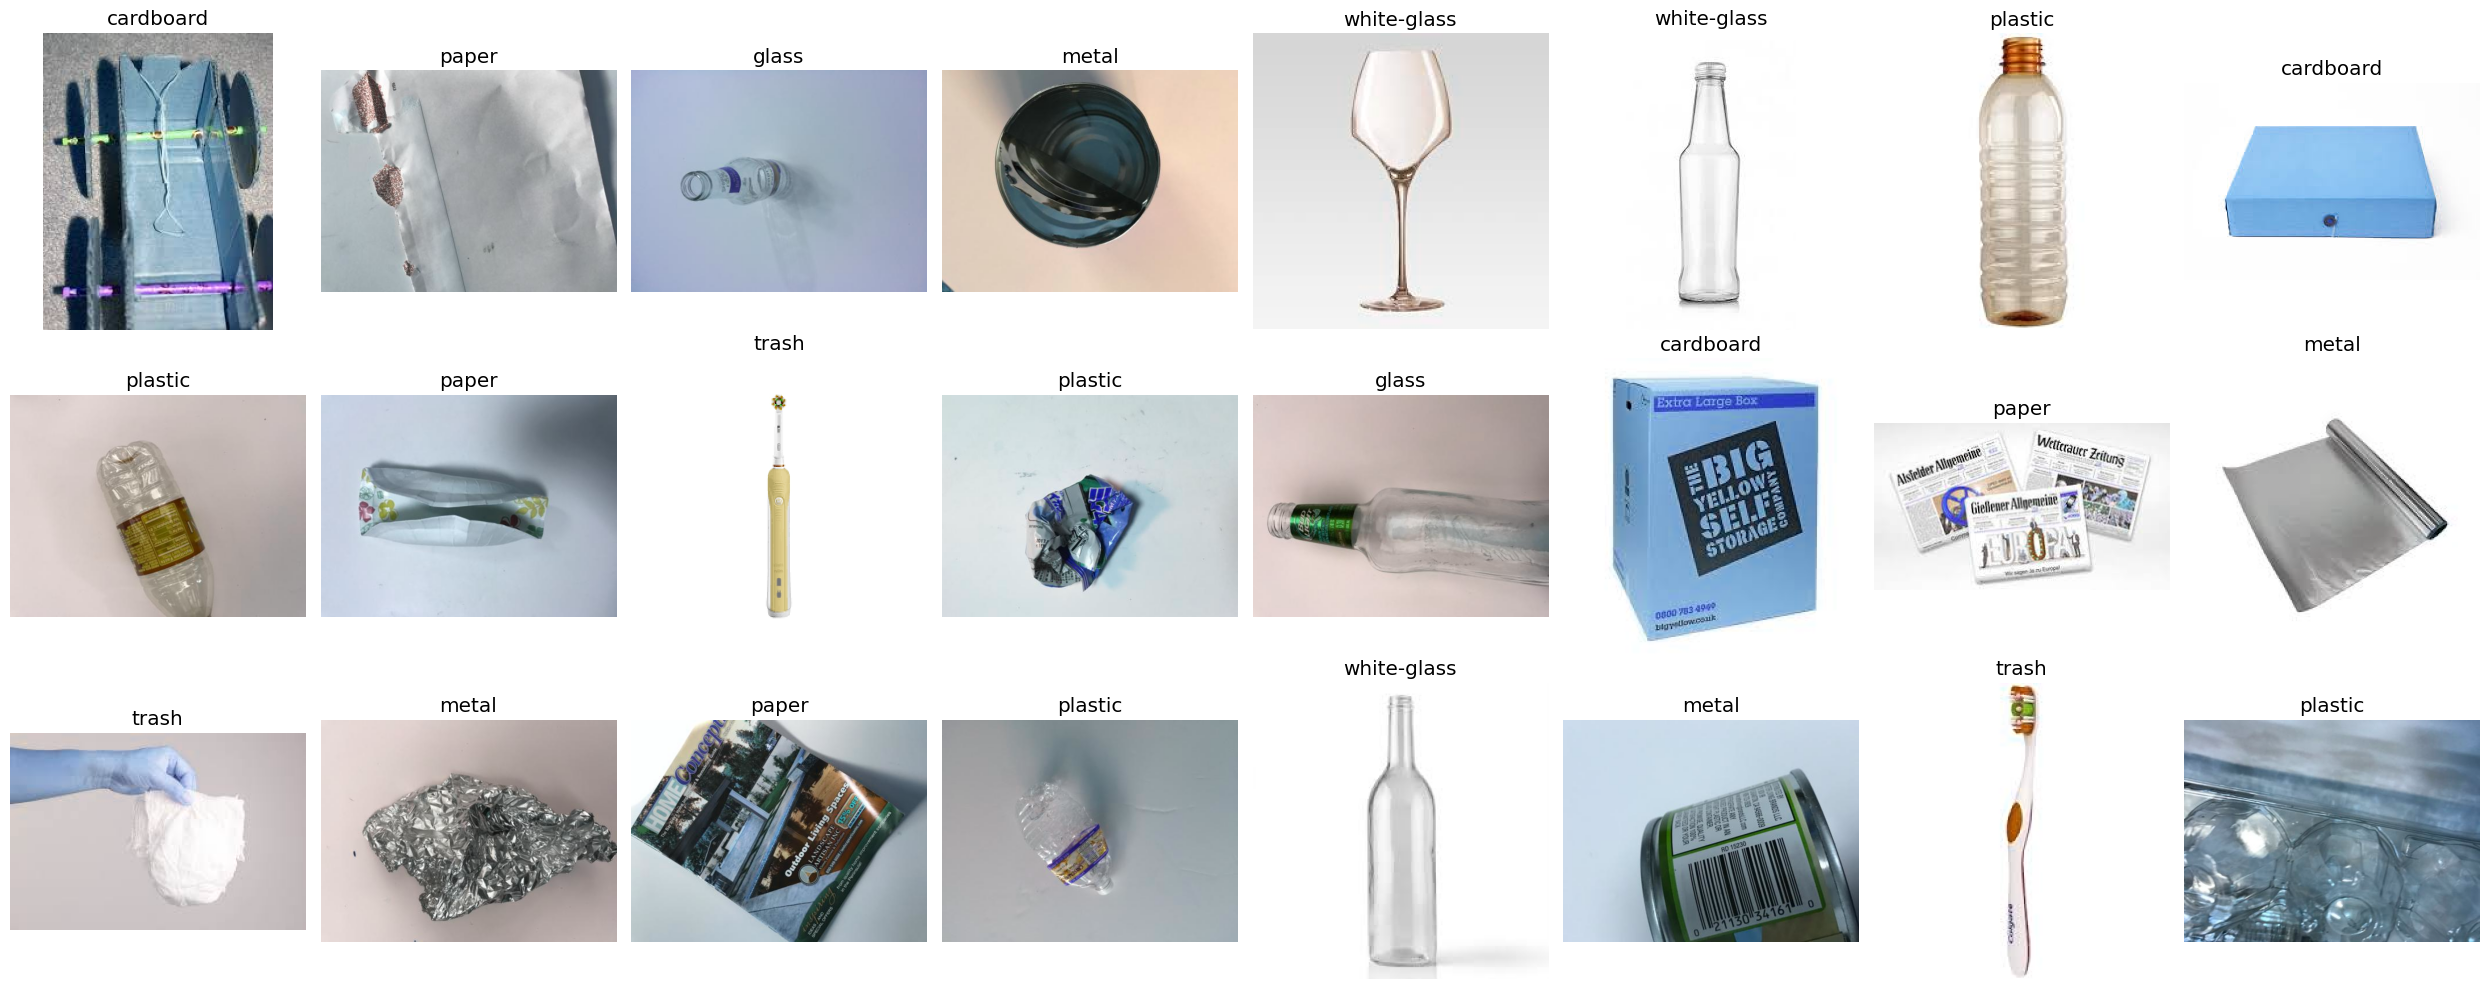

In [11]:
imgPaths = df['imgPath']
fig, axs = plt.subplots(3, 8, figsize=(25, 10))

axs = axs.flatten()

for ax,imgPath in zip(axs , imgPaths):
    label = str(imgPath).split('/')[-2]    # extract label of an imgae from a path 
    img = cv2.imread(imgPath)
    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')
    
plt.tight_layout()
plt.show()

In [12]:
datagenTrain = ImageDataGenerator(
            rescale=1./255,
            zoom_range=(1.0, 1.2),   # zoom in 
            horizontal_flip=True,
            vertical_flip=True,
            rotation_range=45,
)

In [13]:
IMG_SIZE = (224,224)

trainGenerator = datagenTrain.flow_from_dataframe(
    trainDf ,
    x_col='imgPath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=64 ,                     
    class_mode='categorical'
)


datagenTest = ImageDataGenerator( rescale=1./255 )

testGenerator = datagenTest.flow_from_dataframe(
    testDf ,
    x_col='imgPath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=8 ,
    class_mode='categorical',
    shuffle=False
)


print(f"Training set size: {trainGenerator.samples}")
print(f"Testing set size: {testGenerator.samples}")

Found 6434 validated image filenames belonging to 6 classes.
Found 1140 validated image filenames belonging to 6 classes.
Training set size: 6434
Testing set size: 1140


In [14]:
weights_path = '/kaggle/input/mobiles/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224_no_top.h5'
with tf.device('/GPU:0'):          # to use GPU
    Model = Sequential([
        

    
        MobileNetV2(weights=weights_path, include_top=False, input_shape=(224,224,3)),
        
        Flatten(),                                     
        Dense(64,activation='relu'),
        
        BatchNormalization(),
        
        Dropout(0.08),
        Dense(6 ,activation='softmax')
    ])


In [15]:
preTrainedModel = Model.layers[0]
for layer in preTrainedModel.layers[:-4]:
    layer.trainable = False

In [16]:
Model.compile(optimizer='adam',loss='categorical_crossentropy' ,metrics=['accuracy'])

In [17]:
history = Model.fit(
trainGenerator,
validation_data = testGenerator,
epochs = 50,
verbose = 1,
callbacks = [tf.keras.callbacks.EarlyStopping(
              patience = 4,
              monitor = 'val_accuracy',
              restore_best_weights = True)])

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


101/101 ━━━━━━━━━━━━━━━━━━━━ 237s 2s/step - accuracy: 0.6878 - loss: 0.9476 - val_accuracy: 0.8053 - val_loss: 0.6570
Epoch 2/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.8737 - loss: 0.3680 - val_accuracy: 0.8895 - val_loss: 0.3452
Epoch 3/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 212s 2s/step - accuracy: 0.9030 - loss: 0.2786 - val_accuracy: 0.8930 - val_loss: 0.3189
Epoch 4/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - accuracy: 0.9250 - loss: 0.2165 - val_accuracy: 0.9044 - val_loss: 0.3166
Epoch 5/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 211s 2s/step - accuracy: 0.9399 - loss: 0.1894 - val_accuracy: 0.9088 - val_loss: 0.2995
Epoch 6/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - accuracy: 0.9500 - loss: 0.1458 - val_accuracy: 0.9026 - val_loss: 0.3320
Epoch 7/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 212s 2s/step - accuracy: 0.9542 - loss: 0.1432 - val_accuracy: 0.8982 - val_loss: 0.3069
Epoch 8/50
101/101 ━━━━━━━━━━━━━━━━━━━━ 209s 2s/step - accuracy: 0.9564 - loss: 0.1347 - val_accuracy: 0.921

In [18]:
Model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 62720)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     4,014,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,127,700 (57.71 MB)

 Trainable params: 4,427,462 (16.89 MB)

 Non-trainable params: 1,845,312 (7.04 MB)

 Optimizer params: 8,854,926 (33.78 MB)

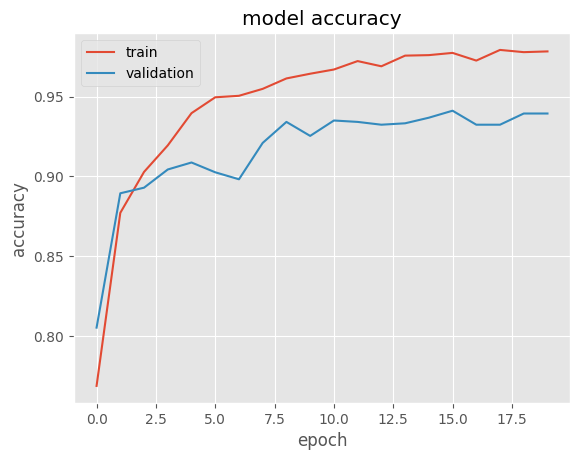

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [20]:
predictions = Model.predict(testGenerator)

143/143 ━━━━━━━━━━━━━━━━━━━━ 25s 164ms/step


In [21]:
test_loss, test_accuracy = Model.evaluate(testGenerator)
test_accuracy

143/143 ━━━━━━━━━━━━━━━━━━━━ 22s 154ms/step - accuracy: 0.9441 - loss: 0.1971


0.9412280917167664

In [22]:
images = []
predictedClasses = []
trueClasses = []


class_labels = list(testGenerator.class_indices.keys())

for i in range(len(testGenerator)):
    img_batch, true_labels_batch = next(testGenerator)  # Get next batch
    true_class_idx = np.argmax(true_labels_batch[0])  # Get the true class index
    
    # Predict the class for the image
    prediction = Model.predict(img_batch)
    predicted_class_idx = np.argmax(prediction[0])  # Get the predicted class index
    
    # Convert the class indices to class labels
    predicted_class = class_labels[predicted_class_idx]
    true_class = class_labels[true_class_idx]
    images.append(np.squeeze(img_batch[0]))
    predictedClasses.append(predicted_class)
    trueClasses.append(true_class)
    
    if i >= 24:  # For example, only plot 24 images
        break

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


In [23]:
Model.save('Garbage_classification.h5')

In [24]:
trainGenerator.class_indices

{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}

In [25]:
trueClasses = testGenerator.classes
trueClasses[:10]

[4, 3, 4, 4, 3, 2, 5, 0, 4, 4]

In [26]:
predictedClasses = predictions.argmax(axis=-1)
predictedClasses[:10]

array([4, 3, 4, 4, 3, 2, 5, 0, 4, 4])

In [27]:
ClassificationReport = classification_report(trueClasses, predictedClasses)
print('Classification Report is : \n', ClassificationReport )

Classification Report is : 
               precision    recall  f1-score   support

           0       0.98      0.95      0.96       195
           1       0.95      0.91      0.93       192
           2       0.92      0.95      0.93       177
           3       0.96      0.98      0.97       247
           4       0.92      0.94      0.93       203
           5       0.90      0.90      0.90       126

    accuracy                           0.94      1140
   macro avg       0.94      0.94      0.94      1140
weighted avg       0.94      0.94      0.94      1140



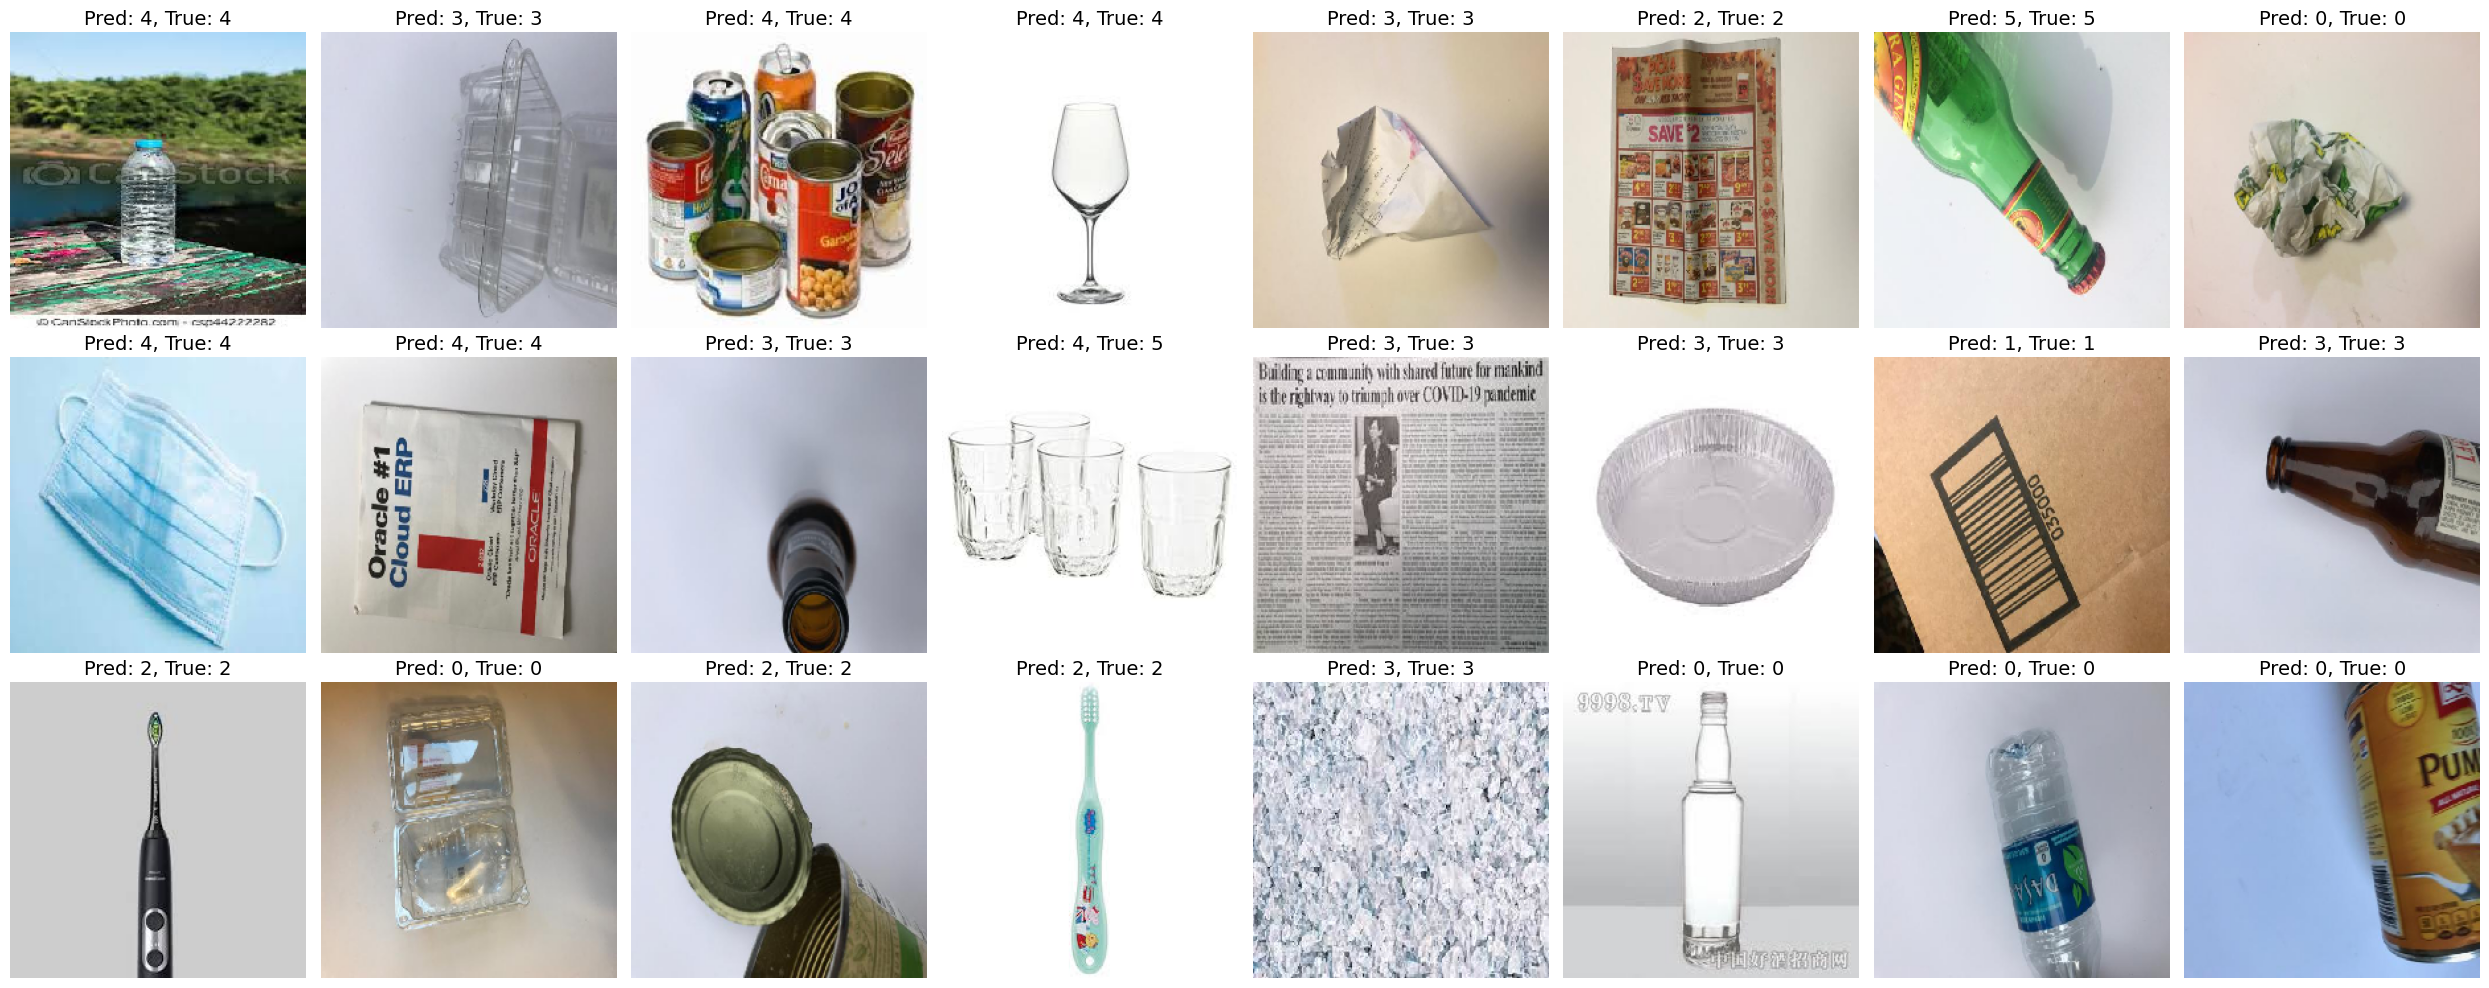

In [28]:
fig, axs = plt.subplots(3, 8, figsize=(25, 10))


axs = axs.flatten()

for ax,img , pred , true in zip(axs , images , predictedClasses , trueClasses):
    ax.imshow(img)
    ax.set_title(f"Pred: {pred}, True: {true}" ,fontsize=14)
    ax.axis('off')
    
plt.tight_layout()
plt.show()

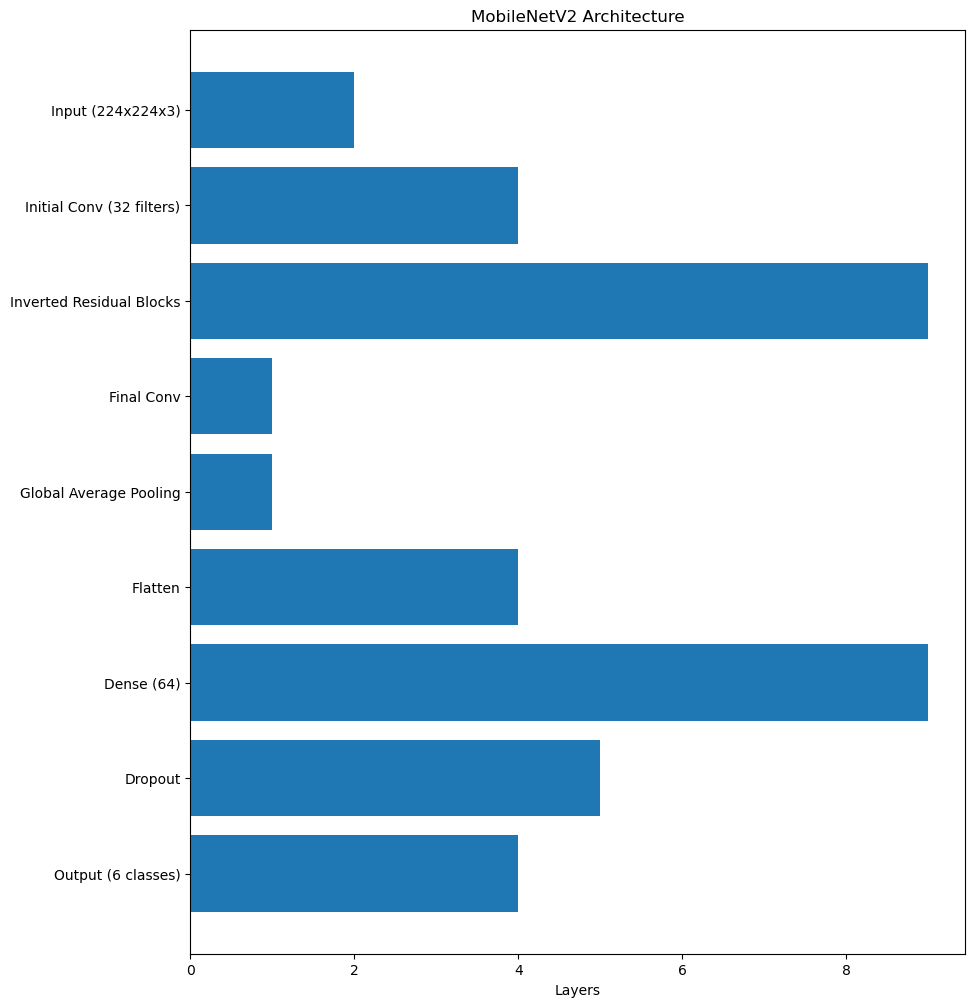

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure
fig, ax = plt.subplots(figsize=(10, 12))

# Draw layers
layers = ['Input (224x224x3)', 'Initial Conv (32 filters)', 
          'Inverted Residual Blocks', 
          'Final Conv', 'Global Average Pooling', 
          'Flatten', 'Dense (64)', 'Dropout', 
          'Output (6 classes)']

y_pos = np.arange(len(layers))
ax.barh(y_pos, np.random.randint(1, 10, size=len(layers)), align='center')
ax.set_yticks(y_pos)
ax.set_yticklabels(layers)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Layers')
ax.set_title('MobileNetV2 Architecture')

plt.show()
